# __1. Thư viện__

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd "/content/drive/MyDrive/Colab Notebooks/Code/NopThay"

In [3]:
# !pip install keras-tuner
# !pip install import-ipynb
# !pip install underthesea
# !pip install advertools
# !pip install emoji
# !pip install regex

In [4]:
import pandas as pd
import numpy as np
import torch
import ast

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split

import string
import advertools as adv
import emoji
import regex as re
from underthesea import word_tokenize, pos_tag

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import import_ipynb
import MLTunning as MLT

# __2. Vectorize__

In [6]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(line.strip() for line in f)
    return stopwords

In [7]:
STOPWORDS_FILE = r"C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\vietnamese-stopwords.txt"
stopwords_vietnamese = load_stopwords(STOPWORDS_FILE)

def process_tweet_vietnamese(tweet):

    # Tokenize bằng underthesea (tách từ)
    tweet_tokens = word_tokenize(tweet, format="text").split()

    # Làm sạch token
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_vietnamese and word not in string.punctuation:
            tweets_clean.append(word.lower())  # Đưa về chữ thường

    return tweets_clean

In [8]:
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet_vietnamese(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [9]:
def freq_sentence(keys):
    data_freq = []
    for word in keys:

        pos = 0
        neg = 0

        if (word, 1) in freqs:
            pos = freqs[(word, 1)]

        if (word, 0) in freqs:
            neg = freqs[(word, 0)]

        data_freq.append([word, pos, neg])
    return data_freq

# __3. Phân tích đánh giá câu dài__

### ___3.1. Đọc dữ liệu và xây dựng model___

In [10]:
file_path = r'C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\preprocessed_data.xlsx'
df = pd.read_excel(file_path)
print(df.head())

                                    content_comments  \
0  thay đổi coment tăng  size hãy làm như bạn muố...   
1  quần dày mỗi lần size nhỏ nhắn tin cửa hàng đổ...   
2  đã nhận được đóng gói màu đúng mẫu đúng sau sẽ...   
3  đã nhận được đóng gói sizesẽ khả năng quay lại...   
4  hình ảnh nhận xu và quan đơn giản thôi mua nhi...   

                                         comment_eng  sentiment  \
0  Change the cmt to increase 1 size. Please do a...          0   
1  thick pants\nEvery time the size is small, mes...          0   
2  Received the goods...shop packaged quickly...r...          1   
3  Received the goods...shop packaged quickly...r...          1   
4  The picture of receipt of coin and quan is sim...          0   

                                       word_tokenize  
0  thay_đổi coment tăng size hãy làm như bạn muốn...  
1  quần dày mỗi lần size nhỏ_nhắn tin cửa_hàng đổ...  
2  đã nhận được đóng_gói màu đúng mẫu đúng sau sẽ...  
3  đã nhận được đóng_gói sizesẽ khả_năng

In [16]:
all_positive_tweets = df.loc[df['sentiment'] == 1]['word_tokenize'].to_list()
all_negative_tweets = df.loc[df['sentiment'] == 0]['word_tokenize'].to_list()
all_positive_tweets = [str(t) if isinstance(t, (float, int)) else t for t in all_positive_tweets]
all_negative_tweets = [str(t) if isinstance(t, (float, int)) else t for t in all_negative_tweets]
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))

tweets = all_positive_tweets + all_negative_tweets

# Kiểm tra và xử lý dữ liệu
tweets = [str(tweet) if not isinstance(tweet, str) else tweet for tweet in tweets]  # Chuyển về chuỗi nếu không phải chuỗi
tweets = [tweet for tweet in tweets if tweet.lower() != 'nan' and tweet.strip()]  # Loại bỏ giá trị NaN hoặc chuỗi rỗng

# Xây dựng tần số
freqs = build_freqs(tweets, labels)

In [17]:
def create_data():
    df_ = pd.DataFrame(columns=['bias', 'positive', 'negative', 'sentiment'])
    for idx, tweet in enumerate(all_positive_tweets):
        list_freq = freq_sentence(process_tweet_vietnamese(tweet))
        positive_ = 0
        negative_ = 0
        for i in list_freq:
            positive_ += i[1]
            negative_ += i[2]
        new_row = {'bias': 1, 'positive': positive_, 'negative': negative_, 'sentiment': 1}
        df_.loc[len(df_)] = new_row
    for idx, tweet in enumerate(all_negative_tweets):
        list_freq = freq_sentence(process_tweet_vietnamese(tweet))
        positive_ = 0
        negative_ = 0
        for i in list_freq:
            positive_ += i[1]
            negative_ += i[2]
        new_row = {'bias': 1, 'positive': positive_, 'negative': negative_, 'sentiment': 0}
        df_.loc[len(df_)] = new_row
    return df_

In [18]:
# Hình thành nên tập train
data_train = create_data()

In [19]:
X = data_train.iloc[:, :-1]
y = data_train.iloc[:, -1]

In [20]:
from sklearn.model_selection import train_test_split
X_train, x_val, y_train, val_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

### ___3.2. Mô hình ML - Logistic regresion - full___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best hyperparameters (Logistic regression): {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
Best score (Logistic regression): 0.8798499386768631
Best Logistic regression Accuracy: 0.8798076923076923
Best Logistic regression Precision: 0.8596491228070176
Best Logistic regression Recall: 0.9158878504672897
Best Logistic regression AUC: 0.8819522209779769

Classification Report:  LogisticRegression
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        94
           1       0.92      0.86      0.89       114

    accuracy                           0.88       208
   macro avg       0.88      0.88      0.88       208
weighted avg       0.88      0.88      0.88       208

ROC_AUC_SCORE is  0.8819522209779769


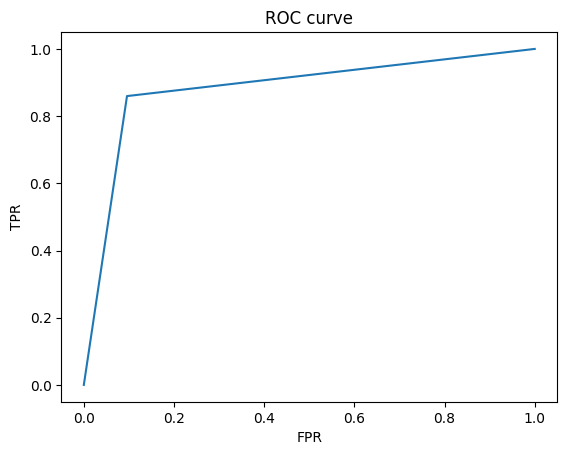

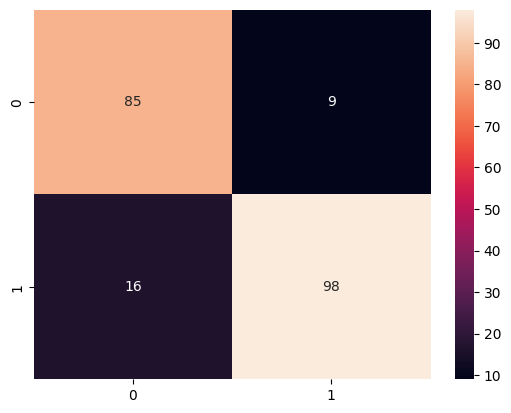

In [21]:
logreg_results_full = MLT.tune_logistic_regression(X_train, y_train, x_val, val_y)

In [22]:
best_rf_model_full= logreg_results_full[0]

### ___3.3. Mô hình ML - Random Forest - full___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best hyperparameters (RandomForestClassifier): {'max_depth': 21, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 53}
Best score (RandomForestClassifier): 0.8558256980015871
Best Random Forest Accuracy: 0.8701923076923077
Best Random Forest Precision: 0.8508771929824561
Best Random Forest Recall: 0.9065420560747663
Best Random Forest AUC: 0.8722471071295259
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        94
           1       0.91      0.85      0.88       114

    accuracy                           0.87       208
   macro avg       0.87      0.87      0.87       208
weighted avg       0.87      0.87      0.87       208

ROC_AUC_SCORE is  0.8722471071295259


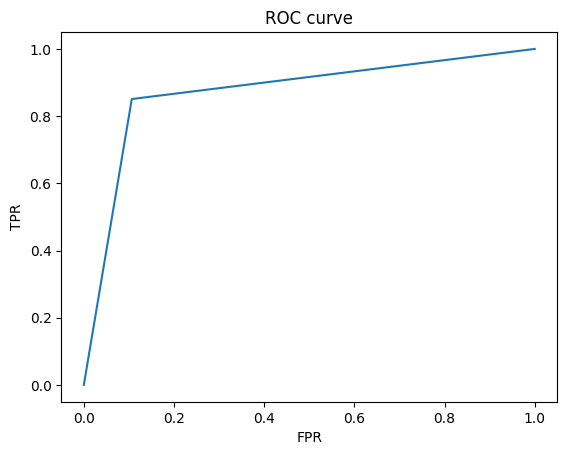

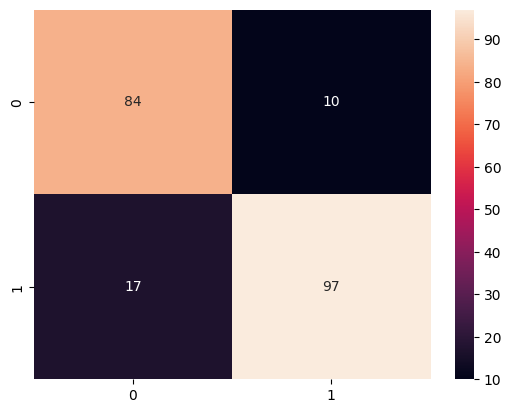

In [23]:
rf_results_full = MLT.tune_random_forest(X_train, y_train, x_val, val_y)

In [24]:
best_rf_model_full = rf_results_full[0]

### ___3.4. Mô hình ML - NaiveBayes - full___

Best hyperparameters (MultinomialNB): {'alpha': 9.089289496854127}
Best score (MultinomialNB): 0.8750306615684295
Best Navie Bayes Accuracy: 0.875
Best Naive Bayes Precision: 0.8245614035087719
Best Navie Bayes Recall: 0.94
Best Naive Bayes AUC: 0.8803658081373646
Classification Report:  MultinomialNB
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        94
           1       0.94      0.82      0.88       114

    accuracy                           0.88       208
   macro avg       0.88      0.88      0.87       208
weighted avg       0.88      0.88      0.88       208

ROC_AUC_SCORE is  0.8803658081373646


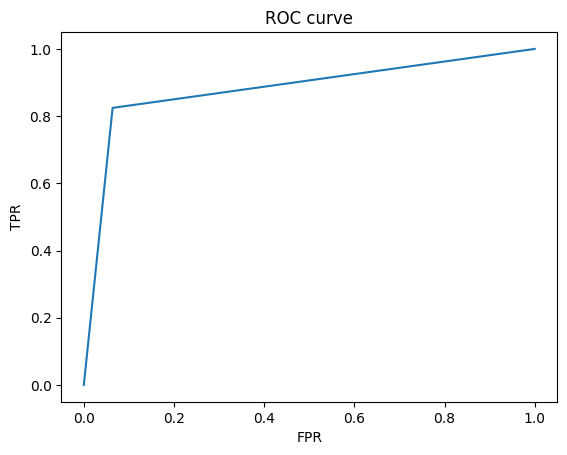

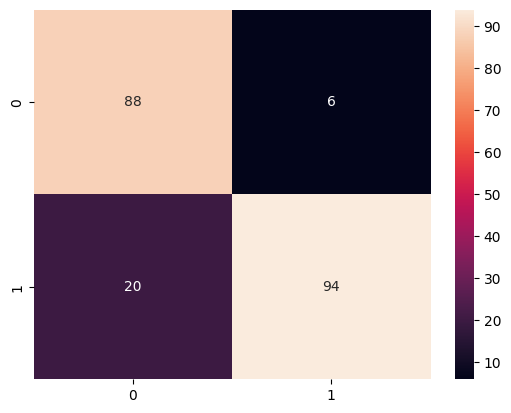

In [25]:
nb_results_full = MLT.tune_multinomial_nb(X_train, y_train, x_val, val_y)

In [26]:
best_nb_results_full = nb_results_full[0]

### ___3.5. Mô hình DL - LSTM - full___

In [28]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()

    model.add(Input(shape=(3, 1)))

    for _ in range(hp.Int('num_lstm_layers', 1, 3)):  # Từ 1 đến 3 lớp LSTM
        model.add(LSTM(hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))
        model.add(Dropout(0.5))

    model.add(GlobalAveragePooling1D())  # Tổng hợp thông tin từ các bước
    model.add(Dense(1, activation='sigmoid'))  # Phân loại nhị phân (0 hoặc 1)

    model.compile(
        loss='binary_crossentropy',  # Sử dụng loss nhị phân cho bài toán phân loại 2 lớp
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        metrics=['accuracy']
    )

    return model

# Đường dẫn và tên dự án
base_dir = r'sentiment_NK'
project_name = 'sentiment_NLPB'
directory = os.path.join(base_dir, project_name)

# Kiểm tra và tạo thư mục nếu chưa có
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")
else:
    print(f"Directory already exists: {directory}")

# Tuner tìm kiếm siêu tham số
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Tối ưu hóa theo độ chính xác trên tập validation
    max_trials=2,  # Số lần thử
    executions_per_trial=1,  # Mỗi thử nghiệm sẽ chạy 1 lần
    directory=base_dir,
    project_name=project_name
)

# Tiến hành tìm kiếm siêu tham số
tuner.search(X_train, y_train, epochs=5, validation_data=(x_val, val_y))

# Lấy các siêu tham số tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Number of LSTM layers: {best_hps.get('num_lstm_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Trial 2 Complete [00h 02m 07s]
val_accuracy: 0.5480769276618958

Best val_accuracy So Far: 0.6682692170143127
Total elapsed time: 00h 03m 44s
Best hyperparameters found:
LSTM units: 32
Number of LSTM layers: 2
Learning rate: 0.007214357610994804


# __4. Phân tích đánh giá câu ngắn__

### ___4.1. Đọc dữ liệu và xây dựng model - split___

In [29]:
file_path1 = r'preprocessed_data1.xlsx'
df1 = pd.read_excel(file_path1)
print(df1.head())

   Unnamed: 0                                            comment  \
0         3.0                                           thun dày   
1         4.0                                    túi có khóa kéo   
2         NaN  mỗi lần size nhỏ nhắn cửa hàng đổi size to hơn...   
3         8.0                                           quần dày   
4         9.0                                  đã nhận được hàng   

   sentiment_manual                                      word_tokenize  
0                 1                                           thun dày  
1                 1                                    túi có khóa kéo  
2                 0  mỗi lần size nhỏ_nhắn cửa_hàng đổi size to hơn...  
3                 1                                           quần dày  
4                 1                                  đã nhận được hàng  


In [33]:
all_positive_tweets = df1.loc[df1['sentiment_manual'] == 1]['word_tokenize'].to_list()
all_negative_tweets = df1.loc[df1['sentiment_manual'] == 0]['word_tokenize'].to_list()
all_positive_tweets = [str(t) if isinstance(t, (float, int)) else t for t in all_positive_tweets]
all_negative_tweets = [str(t) if isinstance(t, (float, int)) else t for t in all_negative_tweets]
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))
tweets = all_positive_tweets + all_negative_tweets
tweets = [str(t) if not isinstance(t, str) else t for t in tweets]

freqs = build_freqs(tweets, labels)

In [34]:
# Hình thành nên tập train
data_train = create_data()

In [35]:
X = data_train.iloc[:, :-1]
y = data_train.iloc[:, -1]

In [36]:
from sklearn.model_selection import train_test_split
X_train, x_val, y_train, val_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

### ___4.2. ML-Logistic regression___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best hyperparameters (Logistic regression): {'solver': 'saga', 'penalty': 'l2', 'C': 0.001}
Best score (Logistic regression): 0.8213028392570895
Best Logistic regression Accuracy: 0.826163818503241
Best Logistic regression Precision: 0.9138339920948617
Best Logistic regression Recall: 0.8614008941877794
Best Logistic regression AUC: 0.7416392182696531

Classification Report:  LogisticRegression
              precision    recall  f1-score   support

           0       0.69      0.57      0.63       432
           1       0.86      0.91      0.89      1265

    accuracy                           0.83      1697
   macro avg       0.78      0.74      0.76      1697
weighted avg       0.82      0.83      0.82      1697

ROC_AUC_SCORE is  0.7416392182696531


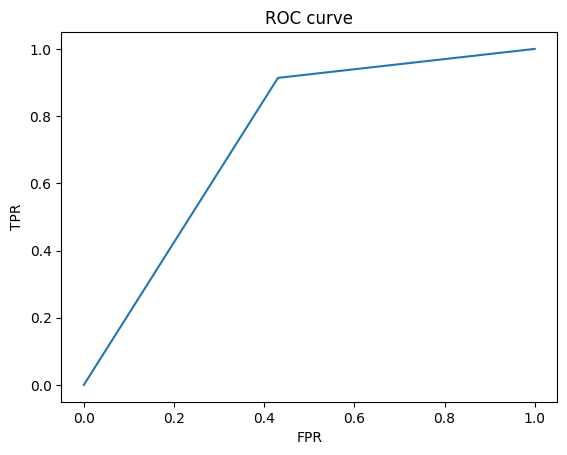

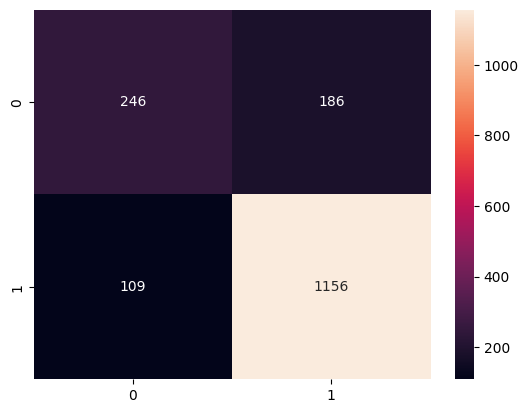

In [37]:
logreg_results_split = MLT.tune_logistic_regression(X_train, y_train, x_val, val_y)

In [38]:
best_logreg_model_split = logreg_results_split[0]

### ___4.3. ML-Random Forest___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best hyperparameters (RandomForestClassifier): {'max_depth': 44, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 272}
Best score (RandomForestClassifier): 0.8507675794413518
Best Random Forest Accuracy: 0.8456098998232174
Best Random Forest Precision: 0.9241106719367589
Best Random Forest Recall: 0.8756554307116104
Best Random Forest AUC: 0.7699257063387498
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       432
           1       0.88      0.92      0.90      1265

    accuracy                           0.85      1697
   macro avg       0.81      0.77      0.78      1697
weighted avg       0.84      0.85      0.84      1697

ROC_AUC_SCORE is  0.7699257063387498


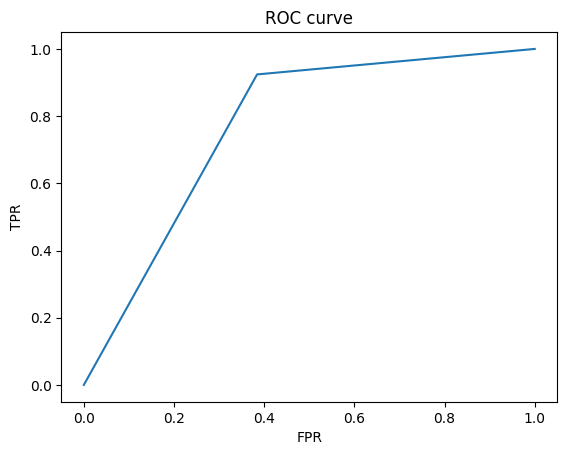

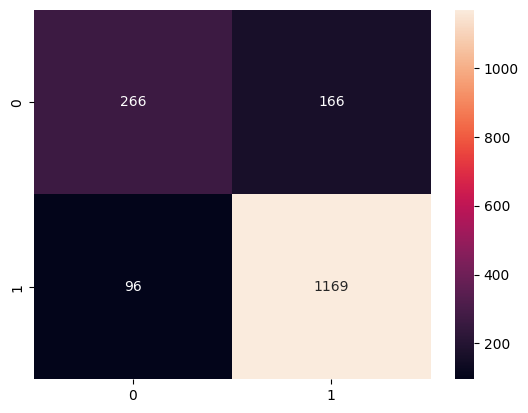

In [39]:
rf_results_split = MLT.tune_random_forest(X_train, y_train, x_val, val_y)

In [40]:
best_rf_model_split = rf_results_split[0]

### ___4.4. ML-Navie Bayes___

Best hyperparameters (MultinomialNB): {'alpha': 4.668108768087782}
Best score (MultinomialNB): 0.7307018752923531
Best Navie Bayes Accuracy: 0.7289334119033589
Best Naive Bayes Precision: 0.6948616600790514
Best Navie Bayes Recall: 0.9223504721930745
Best Naive Bayes AUC: 0.7617826818913775
Classification Report:  MultinomialNB
              precision    recall  f1-score   support

           0       0.48      0.83      0.61       432
           1       0.92      0.69      0.79      1265

    accuracy                           0.73      1697
   macro avg       0.70      0.76      0.70      1697
weighted avg       0.81      0.73      0.75      1697

ROC_AUC_SCORE is  0.7617826818913775


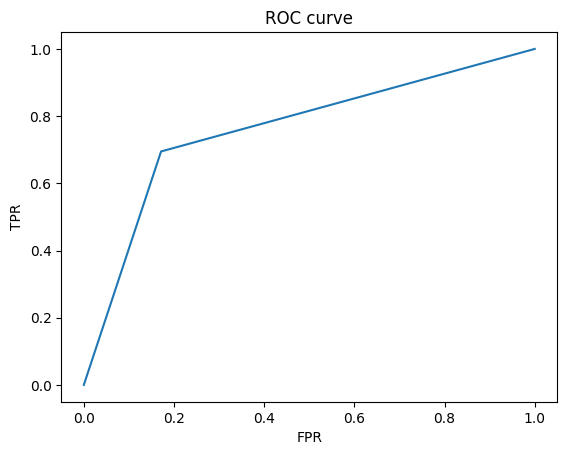

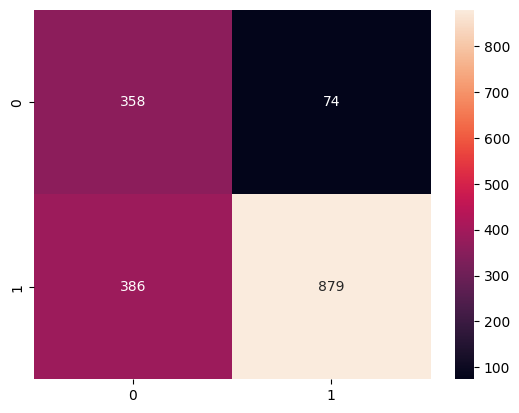

In [41]:
nb_results_split = MLT.tune_multinomial_nb(X_train, y_train, x_val, val_y)

In [42]:
best_nb_results_split = nb_results_split[0]

### ___4.5. DL-LSTM___

In [43]:
# Đường dẫn và tên dự án
base_dir = r'D:\\sentiment_NK'
project_name = 'Sentiment_NLP_SplitB'
directory = os.path.join(base_dir, project_name)

# Kiểm tra và tạo thư mục nếu chưa có
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")
else:
    print(f"Directory already exists: {directory}")

# Tuner tìm kiếm siêu tham số
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Tối ưu hóa theo độ chính xác trên tập validation
    max_trials=2,  # Số lần thử
    executions_per_trial=1,  # Mỗi thử nghiệm sẽ chạy 1 lần
    directory=base_dir,
    project_name=project_name
)

# Tiến hành tìm kiếm siêu tham số
tuner.search(X_train, y_train, epochs=5, validation_data=(x_val, val_y))

# Lấy các siêu tham số tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Number of LSTM layers: {best_hps.get('num_lstm_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Directory already exists: D:\\sentiment_NK\Sentiment_NLP_SplitB
Reloading Tuner from D:\\sentiment_NK\Sentiment_NLP_SplitB\tuner0.json
Best hyperparameters found:
LSTM units: 96
Number of LSTM layers: 2
Learning rate: 0.0005061117544320517
